In [1]:
from rdflib import Graph, Namespace, Literal, URIRef
from rdflib import RDF, RDFS, OWL, XSD
import json

SCHEMA = Namespace("https://schema.org/")
DCTERMS = Namespace("http://purl.org/dc/terms/")
DBO = Namespace("http://dbpedia.org/ontology/")
SOGIDES = Namespace("http://www.sogides.com/")
SOGIDES_PROP = Namespace("http://www.sogides.com/prop/")
BANQ = Namespace("http://banq.qc.ca/")
WDT = Namespace("http://www.wikidata.org/prop/direct/")
WD = Namespace("http://www.wikidata.org/entity/")

# Chargement des graphes RDF

Nos disposons de cinq graphes RDF distincts:

* Celui extrait des donnnées fournies par Messagerie ADP (séparé en deux: un graphe pour les auteurs et un autre pour les livres)
* Celui extrait à partir du site de l'Infocentre littéraire des écrivains, L’ÎLE (http://recif.litterature.org/)
* Celui construit à partir du Dépôt légal de BAnQ (https://www.donneesquebec.ca/recherche/fr/dataset/publications-recues-en-depot-legal)
* Celui extrait des données fournies par Hurtubise
* Celui extrait des données récupérées par Grégoire sur Babelio(séparé en deux: un graphe pour les auteurs et un autre pour les livres)

In [2]:
grapheAuteursADP = Graph()
grapheAuteursADP.parse('../Graphes/grapheADPAuteurs.rdf')


<Graph identifier=Ned65afe4141d4d6dad899a2e92c52fca (<class 'rdflib.graph.Graph'>)>

In [3]:
grapheLivresADP = Graph()
grapheLivresADP.parse('../Graphes/grapheADPLivres.rdf')


<Graph identifier=N9d513508a5cd4f739c66dd9d36ec51df (<class 'rdflib.graph.Graph'>)>

In [4]:
grapheILE = Graph()
grapheILE.parse('../Graphes/grapheILE.rdf')

<Graph identifier=N2e60328fd4bc4d22ade779a71fdc8da5 (<class 'rdflib.graph.Graph'>)>

In [5]:
grapheDepotLegal = Graph()
grapheDepotLegal.parse('../Graphes/grapheDepotLegal.rdf')

<Graph identifier=N79476005fccd46ee961dcdeb753961bb (<class 'rdflib.graph.Graph'>)>

In [6]:
grapheHurtubise = Graph()
grapheHurtubise.parse('../Graphes/grapheHurtubise.rdf')

<Graph identifier=Nef0f468a87514200b63a45fa211841c1 (<class 'rdflib.graph.Graph'>)>

In [7]:
grapheBabelio = Graph()
grapheBabelio.parse('../Graphes/grapheBabelio.rdf')

<Graph identifier=N120263fdaad347f384ccf3994e6a18e9 (<class 'rdflib.graph.Graph'>)>

In [8]:
def nettoyer_unicode(c):
    liste_codes =  {
        'Ã\xa0': 'à',
        'Ã€': 'À',
        'Ã¢': 'â',
        'ã': 'â',
        'Ã‚': 'Â',
        'Ã©': 'é',
        'Ã©': 'é',
        'ã‰': 'é',
        'ãƒâ©': 'é',
        'Ã\x89': 'É',
        'Ã\xa8': 'è',
        'Ã\xaa': 'ê',
        'Ã\x8a': 'Ê', 
        'Ã¨': 'ê',       
        'Ã«': 'ë',
        'Ã®':'î',
        'Ã\x8e':'Î',        
        'Ã¯': 'ï', 
        'Ã´': 'ô',
        'Ã\x94': 'Ô',
        'Ã¹': 'ù', 
        'Ã»': 'û',
        'Å\x93': 'œ', 
        'Â«': '«',
        'Â»': '»',
        'Ã§': 'ç',
        'Ã\x87': 'Ç',
        'Âº': 'º',
        'â€™': '’',
        'â\x80\x99': '’',
        'â\x80\xa6' : '…',
    }
    
    for code in liste_codes:
        c = c.replace(code,liste_codes[code])
        
    return c

In [9]:
import re

# def format_isbn(s):
#     """
#     nettoyage du isbn, x-xxxxx-xxx-x (info) --> xxxxxxxxxx
#     :param string: chaine de caractère à normaliser
#     :return: même chaine de caractère normalisée
#     """
#     string = re.sub(r'[^0-9]', '', s)
#     if len(string) == 10:
#         string = '978' + string
#     string = string[:-1] + 'X'
#     return string

# import re

def format_isbn(s):
    """
    nettoyage du isbn, x-xxxxx-xxx-x (info) --> xxxxxxxxxx
    :param string: chaine de caractère à normaliser
    :return: même chaine de caractère normalisée
    """
    string = re.sub(r'\D', '', s)
    if len(string) == 9 or len(string) == 12:
        string += 'X'
    if len(string) == 10:
        string = '978' + string
    string = string[:-1] + 'X' 
    return string

print(format_isbn('289006591X'))
print(format_isbn('9872890065913'))
print(format_isbn('987289006591X'))
print(format_isbn('2890065912'))
print(format_isbn('292088736X (br.)'))

978289006591X
987289006591X
987289006591X
978289006591X
978292088736X


# Extraction de livres de ADP

In [10]:
qres = grapheLivresADP.query(
    """PREFIX schema: <https://schema.org/>
       SELECT DISTINCT ?livre ?titre ?isbn
       WHERE {
          ?livre a <http://www.sogides.com/classe/Livre> ;
             schema:name ?titre ;
             schema:isbn ?isbn .
       }""")

#adp auteur
#  ?auteur a <http://www.sogides.com/classe/Auteur> ;
#              schema:name  ?nom . 

livres_adp = {}
for r in qres:
    livres_adp[format_isbn(r['isbn'].toPython())] = {
         "isbn": r['isbn'].toPython(), 
         "titre_raw": r['titre'], 
         "titre": nettoyer_unicode(r['titre'])
     }

In [11]:
print(len(livres_adp))

15469


# Extraction de livres Dépôt Légal

In [12]:
qres = grapheDepotLegal.query(
     """PREFIX ns1: <https://schema.org/>
        SELECT DISTINCT ?livre ?isbn ?titre
        WHERE {
            ?livre a <http://dbpedia.org/ontology/Book>;
                ns1:name ?titre ;
                ns1:isbn ?isbn .
        }""")

livres_depot = {}
for r in qres:
    livres_depot[format_isbn(r['isbn'].toPython())] = {
         "isbn": r['isbn'].toPython(), 
         "titre_raw": r['titre'],
         "titre": nettoyer_unicode(r['titre'])
     }

In [13]:
print(len(livres_depot))

60248


# Extraction livres Dépôt ILE

In [14]:
qres = grapheILE.query(
     """PREFIX schema: <https://schema.org/>
        SELECT DISTINCT ?livre ?isbn ?titre
        WHERE {
            ?livre a <http://recif.litterature.org/ontologie/classe/oeuvre> ;
                schema:name ?titre ;
                schema:isbn ?isbn .
        }""")


#ile auteur
#            ?auteur a <http://recif.litterature.org/ontologie/classe/ecrivain> ;
#              schema:givenName ?prenom ;
#              schema:familyName ?nom .

livres_ile = {}

for r in qres:
    isbns = re.split("[|;,]", r['isbn'])
    for isbn in isbns:
        livres_ile[format_isbn(isbn)] = {
            "isbn": r['isbn'].toPython(), 
            "titre_raw": r['titre'], 
            "titre": nettoyer_unicode(r['titre'])
        }

In [15]:
print(len(livres_ile))
print(livres_ile['978292088736X'])

21073
{'isbn': '292088736X (br.)', 'titre_raw': rdflib.term.Literal('La nuit verte du parc Labyrinthe'), 'titre': 'La nuit verte du parc Labyrinthe'}


# Extraction livres Hurtubise

In [16]:
qres = grapheHurtubise.query(
     """PREFIX ns1: <http://schema.org/>
        PREFIX hurtubise: <https://distributionhmh.com/onto/>
        SELECT DISTINCT ?livre ?titre ?titreAlt ?isbn ?isbnpdf ?isbnepub
        WHERE {
            ?livre a <http://schema.org/Book> ;
                ns1:name ?titre ;
                ns1:isbn ?isbn .
            OPTIONAL {
            ?livre ns1:alternativeHeadline ?titreAlt;
            }
            OPTIONAL {
            ?livre hurtubise:isbnpdf ?isbnpdf } .
            OPTIONAL {
            ?livre hurtubise:isbnepub ?isbnepub }
        }""")

livres_hurtubise = {}
for r in qres:
    livres_hurtubise[format_isbn(r['isbn'].toPython())] = {
         "isbn": r['isbn'].toPython(), 
         "titre_raw": r['titre'], 
         "titre": nettoyer_unicode(r['titre'] + ' ' + r['titreAlt'])
     }
    if r['isbnpdf']:
        livres_hurtubise[format_isbn(r['isbnpdf'].toPython())] = {
         "isbn": r['isbnpdf'].toPython(), 
         "titre_raw": r['titre'], 
         "titre": nettoyer_unicode(r['titre'] + ' ' + r['titreAlt'])
     }
    if r['isbnepub']:
        livres_hurtubise[format_isbn(r['isbnepub'].toPython())] = {
         "isbn": r['isbnepub'].toPython(), 
         "titre_raw": r['titre'], 
         "titre": nettoyer_unicode(r['titre'] + ' ' + r['titreAlt'])
     }

In [17]:
print(len(livres_hurtubise))
print(livres_hurtubise['978289647821X'])

2497
{'isbn': '9782896478217', 'titre_raw': rdflib.term.Literal('Marika et ses amis - Tome 3'), 'titre': "Marika et ses amis - Tome 3 L'énigme du sommet Noir"}


# Extraction livres Babelio

In [18]:
qres = grapheBabelio.query(
     """PREFIX ns1: <https://schema.org/>
        SELECT DISTINCT ?livre ?titre ?isbn
         WHERE {
            ?livre a <https://schema.org/Book> ;
                ns1:name ?titre ;
                ns1:isbn ?isbn .
        }""")

livres_babelio = {}
print(len(qres))
for r in qres:
    livres_babelio[format_isbn(r['isbn'].toPython())] = {
         "isbn": r['isbn'].toPython(), 
         "titre_raw": r['titre'], 
         "titre": nettoyer_unicode(r['titre'])
     }

1793


# Candidats à l'alignement (gold standard)
Livres confirmés comme étant le même par leur isbn

In [19]:
import re

def normalize(string):
    """
    normalise une chaine de caractère pour faciliter leurs comparaisons
    :param string: chaine de caractère à normaliser
    :return: même chaine de caractère normalisée
    """
    try:
        string = re.sub(r'^\W+|\W+$', '', string)
        string = re.sub(r'\W', ' ', string)
        string = re.sub(r' +', ' ', string)
        string = re.sub(r',', '', string)
        return string
    except:
        return None

In [20]:
alignement = {}

set_adp_dep = set(livres_adp) & set(livres_depot)
set_adp_ile = set(livres_adp) & set(livres_ile)
set_adp_hur = set(livres_adp) & set(livres_hurtubise)
set_adp_bab = set(livres_adp) & set(livres_babelio)
set_ile_dep = set(livres_ile) & set(livres_depot)
set_ile_hur = set(livres_ile) & set(livres_hurtubise)
set_ile_bab = set(livres_ile) & set(livres_babelio)
set_dep_hur = set(livres_depot) & set(livres_hurtubise)
set_dep_bab = set(livres_depot) & set(livres_babelio)
set_hur_bab = set(livres_hurtubise) & set(livres_babelio)

isbns = set(set_adp_dep ^ set_adp_ile ^ set_adp_hur ^ set_ile_dep ^ set_ile_hur ^ set_ile_bab ^ set_dep_hur ^ set_dep_bab ^ set_hur_bab)
print(len(isbns))
for isbn in isbns:
    
    value = (isbn, '', '', '', '', '')
    value = list(value)
    
    if isbn in livres_adp:
        value[1] = livres_adp[isbn]
    
    if isbn in livres_ile:
        value[2] = livres_ile[isbn]

    if isbn in livres_depot:
        value[3] = livres_depot[isbn]

    if isbn in livres_hurtubise:
        value[4] = livres_hurtubise[isbn]

    if isbn in livres_babelio:
        value[5] = livres_babelio[isbn]

    alignement[isbn] = value

16103


In [21]:
print(len(alignement))
print(alignement['978289647821X'])

16103
['978289647821X', '', '', {'isbn': '9782896478217', 'titre_raw': rdflib.term.Literal('Marika et ses amis, tome 3'), 'titre': 'Marika et ses amis, tome 3'}, {'isbn': '9782896478217', 'titre_raw': rdflib.term.Literal('Marika et ses amis - Tome 3'), 'titre': "Marika et ses amis - Tome 3 L'énigme du sommet Noir"}, '']


In [22]:
import csv

with open('alignement.csv', 'w') as f:
    
    for isbn, book in alignement.items():  
#         isbn = book[0]
        try:
            adp = normalize(book[1]["titre"])
        except:
            adp = ''
        try:
            ile = normalize(book[2]["titre"])
        except:
            ile = ''
        try:
            depot = normalize(book[3]["titre"])
        except:
            depot = ''
        try:
            hurt = normalize(book[4]["titre"])
        except:
            hurt = ''
        try:
            babelio = normalize(book[5]["titre"])
        except:
            babelio = ''
    
        f.write("%s, %s, %s, %s, %s, %s\n" % (isbn, adp, ile, depot, hurt, babelio))


# Création des paires positives

Pour créer des paires positives il nous faut isoler deux à deux les titres de livres identifiés comme équivalents dans deux sources de données.  

Ensuite, on doit retirer les titres qui sont exactement identiques.

In [23]:
from itertools import combinations
import csv 
import numpy as np

pairs = []
with open('positive.csv', 'w', encoding="utf-8") as f:
    for isbn, book in alignement.items():  
        titres = []
        try:
            titres.append(book[1]["titre"])
        except:
            pass
        try:
            titres.append(book[2]["titre"])
        except:
            pass
        try:
            titres.append(book[3]["titre"])
        except:
            pass
        try:
            titres.append(book[4]["titre"])
        except:
            pass
        try:
            titres.append(book[5]["titre"])
        except:
            pass    
        unique_titres = set(titres)
        if len(unique_titres) > 1 :
            for item in list(combinations(set(titres), 2)):
                pairs.append(item)
            writer = csv.writer(f)
            writer.writerows(list(combinations(set(titres), 2)))
print(len(pairs))
np.save("paires_pos", pairs)
print(pairs)

8962
[('Le défi de Dominic - Nº 133', 'Le défi de Dominic '), ('13 malentendues', '13 malentenduEs'), ('Ce garçon trop doux', 'Ce garçon trop doux ; suivi de, Nuit claire comme le jour'), ("000-terreur au camp d'hiver", "Terreur au camp d'hiver"), ('PTS DEGOUTANTS COQUERELLE', 'La coquerelle'), ('La parade des orages en laisse ', 'La parade des orages en laisse'), ('Léonise Valois, femme de lettres', 'Léonise Valois, femme de lettres (1993)'), ('El recital de los ángeles', 'El recital de los ángeles = [Le récital des anges]'), ('Le géant des sables', 'Geant des sables'), ("Le souffle de l'ange", "Le souffle de l'ange. Tome 1"), ('Félicien et la grotte', 'FELICIEN ET LA GROTTE'), ('Le livre de chevet : un sommeil', 'Le livre de chevet'), ('Les Mutamatak - Nº 2', 'Les Mutamatak'), ('KABOUM T11 LA VISITE', 'Kaboum'), ('Pas de mal à une mouche', 'Pas de mal à  une mouche '), ('La Cathédrale de tout', 'La cathédrale de tout'), ('Pakkal : les larmes de Zipacnà', 'Pakkal'), ("Toute une vie su

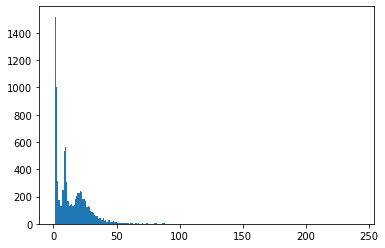

In [24]:
import matplotlib.pyplot as plt
import nltk

dist = []
for pair in pairs:
    dist.append(nltk.edit_distance(pair[0], pair[1]))

plt.hist(dist, bins=range(min(dist), max(dist) + 1, 1))
plt.show()
